**Import all libraries**

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from category_encoders import TargetEncoder
from scipy.stats import skew, boxcox
from datetime import datetime, timedelta

**loading data**

In [271]:
df=pd.read_csv(r"D:\Projects\Copper_modelling\src\data\daily_offers.xlsx.csv")
df.shape

(181673, 14)

In [272]:
data=df.copy()

In [273]:
data.head(3)

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33


In [274]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181672 non-null  float64
 2   quantity tons  181673 non-null  object 
 3   customer       181672 non-null  float64
 4   country        181645 non-null  float64
 5   status         181671 non-null  object 
 6   item type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery date  181672 non-null  float64
 13  selling_price  181672 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 19.4+ MB


# Data Preprocessing

In [275]:
data.drop_duplicates(inplace=True) #droping duplicates
data.shape

(181673, 14)

 **checking for currupt data in each column**

In [276]:
for i in range(len(data.columns)):
    print(data.iloc[:,i].value_counts())

id
EC06F063-9DF0-440C-8764-0B0C05A4F6AE    1
65203CB6-89D8-4BE3-ACBE-E5EDA0F5ACDC    1
3020E716-130E-4456-BD0A-57C4A519BE58    1
588AE510-4CB5-4A28-97D7-7F7A1E0BD0DD    1
15300D43-0ED4-49B2-B2CC-759D03E3EACC    1
                                       ..
679C1F30-3ABA-49F7-8B01-F50FEDD6D916    1
ACDD75A4-85DD-4E44-89E8-0E55CA952F85    1
40F88F5B-6C88-4896-81D0-DEE88A9F1C0A    1
3F6C6143-0A6D-4C87-B05E-1FC6973D173A    1
AD0CA853-AE3C-4B2F-9FBB-8B0B965F84BC    1
Name: count, Length: 181671, dtype: int64
item_date
20201202.0    2779
20210304.0    2088
20201124.0    1991
20210115.0    1928
20200929.0    1870
              ... 
20201219.0       1
20210313.0       1
20191919.0       1
20200829.0       1
19950000.0       1
Name: count, Length: 252, dtype: int64
quantity tons
54.15113862    1
75.11072642    1
32.43164392    1
31.92534499    1
132.3113848    1
              ..
13.86959008    1
2.738535634    1
233.2640131    1
11.94017945    1
406.6865384    1
Name: count, Length: 181673, dtype

**column "item_date " and "delivery date"**

In [277]:
# Convert the column to string
time_cols=['item_date','delivery date']
for f in time_cols:
    data[f] = data[f].astype(str)

    # Remove the '.0' at the end
    data[f] = data[f].str[:-2]

    # Replace invalid dates with NaN
    data.loc[data[f].str[-4:] == '0000', 'item_date'] = pd.NA

    # Convert to datetime format
    data[f] = pd.to_datetime(data[f], format='%Y%m%d', errors='coerce')
    
data['delivery_dats']=data['item_date'].dt.day-data['delivery date'].dt.day


In [278]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             181671 non-null  object        
 1   item_date      181670 non-null  datetime64[ns]
 2   quantity tons  181673 non-null  object        
 3   customer       181672 non-null  float64       
 4   country        181645 non-null  float64       
 5   status         181671 non-null  object        
 6   item type      181673 non-null  object        
 7   application    181649 non-null  float64       
 8   thickness      181672 non-null  float64       
 9   width          181673 non-null  float64       
 10  material_ref   103754 non-null  object        
 11  product_ref    181673 non-null  int64         
 12  delivery date  181670 non-null  datetime64[ns]
 13  selling_price  181672 non-null  float64       
 14  delivery_dats  181667 non-null  float64       
dtype

In [279]:
#dropping unwanted columns
data.drop(columns=['id','item_date','customer','material_ref','delivery date'],inplace=True)

In [280]:
# converting feature data types to correct format
# removing currupt data "e"
data=data.loc[data['quantity tons']!="e"]
data['quantity tons']=data['quantity tons'].astype('float64')
data['product_ref']=data['product_ref'].astype('object')
data['application']=data['application'].astype('object')
data['country']=data['country'].astype('object')

# Encoding
* Categorical columns

In [281]:
data = data[data['status'].isin(['Won', 'Lost'])]
data['status'] = data['status'].map({'Won': 1, 'Lost': 0})

data = pd.get_dummies(data, columns=['item type'], dtype='int')


from category_encoders import TargetEncoder
# Create a list of columns to encode
columns_to_encode = ['country', 'application', 'product_ref']

# Create the encoder
encoder = TargetEncoder()

# Fit and transform the data
data[columns_to_encode] = encoder.fit_transform(data[columns_to_encode], data['selling_price'])

final_data=data.copy()

In [282]:
final_data.shape

(150447, 16)

In [283]:
final_data.head()

,quantity tons,country,status,application,thickness,width,product_ref,selling_price,delivery_dats,item type_IPL,item type_Others,item type_PL,item type_S,item type_SLAWR,item type_W,item type_WI
0,54.151139,841.729796,1,794.543910,2.00,1500.0,731.236407,854.00,0.0,0,0,0,0,0,1,0
1,768.024839,836.850676,1,946.741876,0.80,1210.0,888.077325,1047.00,0.0,0,0,0,0,0,1,0
2,386.127949,882.090518,1,717.097104,0.38,952.0,743.479305,644.33,0.0,0,0,0,0,0,0,1
3,202.411065,845.142239,1,715.183473,2.30,1317.0,888.077325,768.00,0.0,0,0,0,1,0,0,0
4,785.526262,841.729796,1,794.543910,4.00,2000.0,684.282650,577.00,0.0,0,0,0,0,0,1,0



# EDA

Checking for outliers

In [284]:
final_data.describe()

,quantity tons,country,status,application,thickness,width,product_ref,selling_price,delivery_dats,item type_IPL,item type_Others,item type_PL,item type_S,item type_SLAWR,item type_W,item type_WI
count,150447.000000,150447.000000,150447.000000,150447.000000,150447.000000,150447.000000,150447.000000,150446.000000,150442.00000,150447.000000,150447.000000,150447.000000,150447.000000,150447.000000,150447.000000,150447.000000
mean,94.458732,825.767342,0.771095,825.764464,2.618373,1297.842266,825.741828,825.764922,14.09829,0.000179,0.003077,0.033447,0.348727,0.000007,0.611212,0.003350
std,440.947272,36.678845,0.420129,79.075731,7.115470,266.156259,124.583115,290.880397,8.74026,0.013395,0.055390,0.179801,0.476569,0.002578,0.487477,0.057782
min,-2000.000000,654.940260,0.000000,562.527536,0.180000,1.000000,684.282650,-1160.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.698733,806.567495,1.000000,794.543910,0.740000,1176.500000,731.236407,671.000000,7.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.934641,813.734505,1.000000,794.543910,1.500000,1250.000000,800.778020,811.000000,14.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,64.868197,841.729796,1.000000,941.734793,3.000000,1500.000000,888.077325,951.000000,22.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,70252.363070,1139.454395,1.000000,1058.905015,2500.000000,2990.000000,1522.413906,81236.140000,30.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


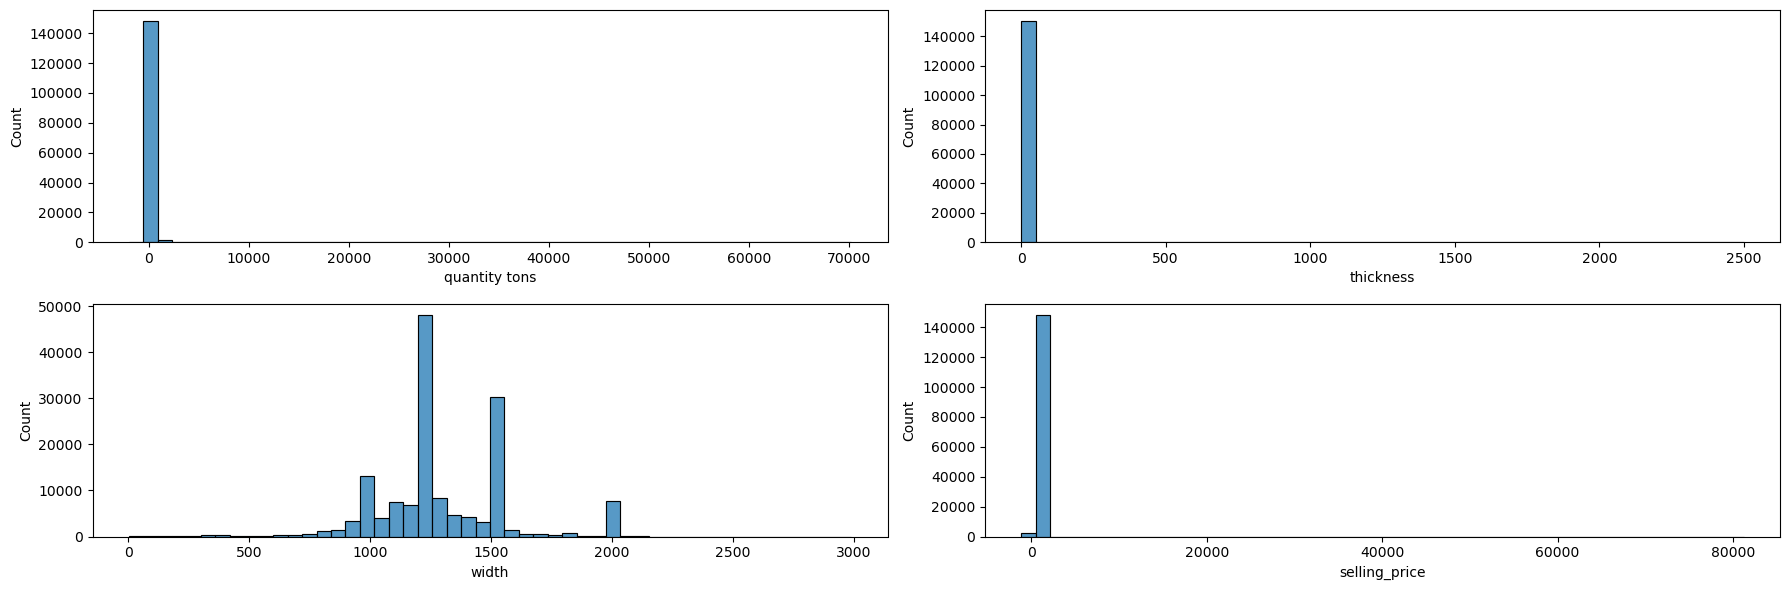

In [285]:
# Plotting distributions of some numerical columns
cols=['quantity tons', 'thickness', 'width','selling_price']
fig, axes = plt.subplots(2,2, figsize=(18,6))
for i,col in enumerate(cols):
    sns.histplot(final_data[col], bins=50, ax=axes[i//2, i%2])
plt.tight_layout()
plt.show()


* from above graphs and statistics we can see that, data has outliers and also skewed.
* Data needd to be transformed

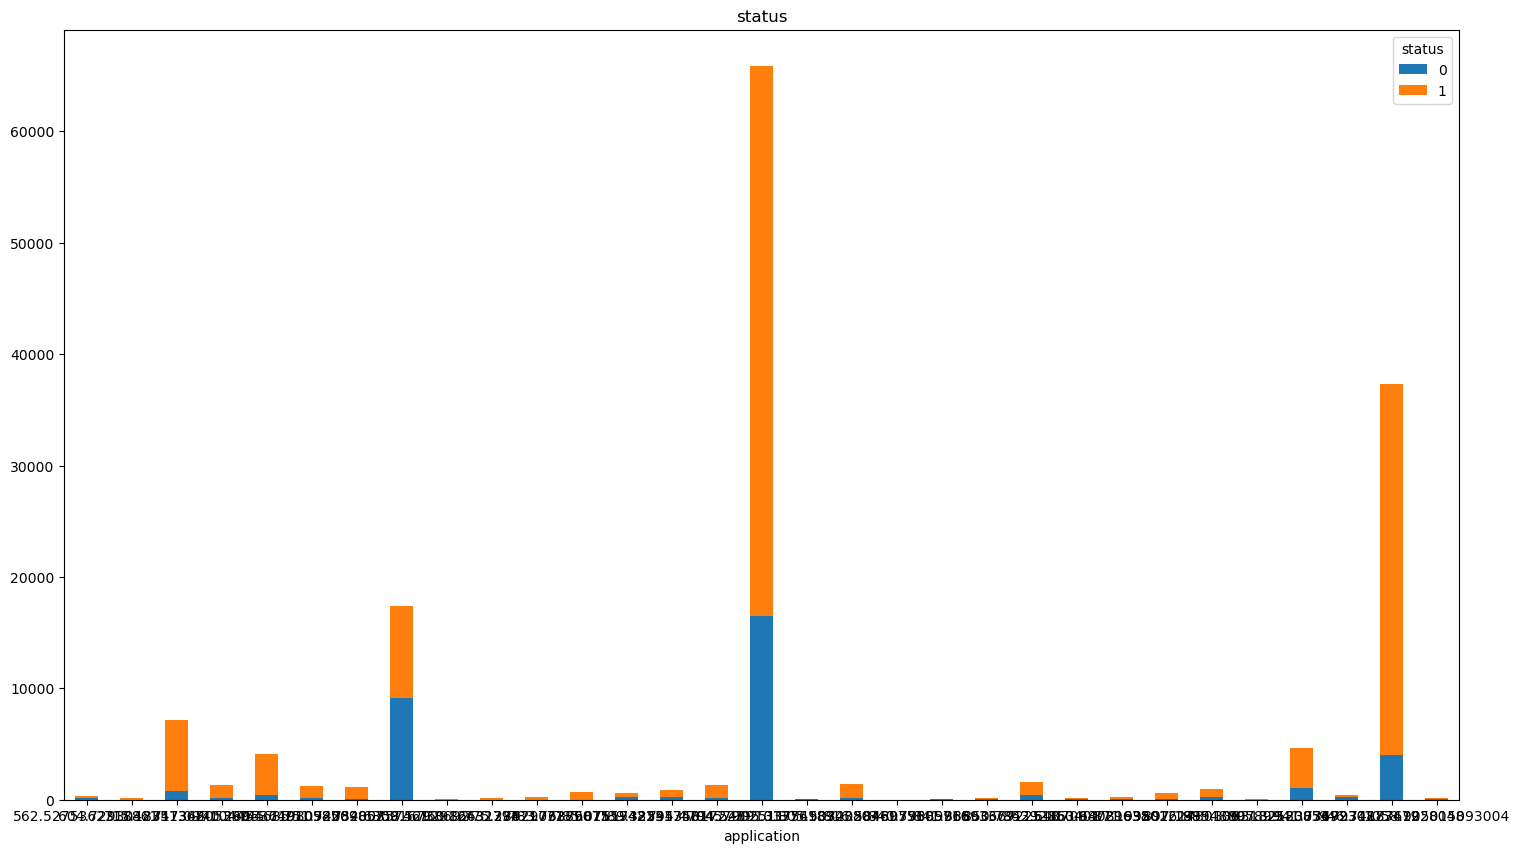

In [286]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )
    plt.show()
    

#No of success(won) based on applications
x = final_data.groupby([final_data["application"],final_data["status"]])["application"].count().unstack(level=1)
plot_stacked_bars(x,'status')

In [287]:
# Application no 10,15,41 and 59 have high rate of success rate

# Data transformation and outlier removal

In [288]:
cols=['quantity tons', 'thickness', 'width','selling_price']
def out_removal(cols):
    global final_data
    for col in cols:
        #IQR
        Q3=final_data[col].quantile(0.75)
        Q1=final_data[col].quantile(0.25)
        IQR=Q3-Q1

        upper_limit=Q3+1.5*IQR
        lower_limit=Q1-1.5*IQR
        # Filter out the outliers
        final_data = final_data.loc[~(final_data[col]>(2*upper_limit)) & (final_data[col]>=0)]
    return final_data

final_data=out_removal(cols)
print(final_data.shape)


(140209, 16)


Lambda value used for Transformation: 0.16566176182102382
Lambda value used for Transformation: -0.15661990549881208
Lambda value used for Transformation: 0.8944320487982019


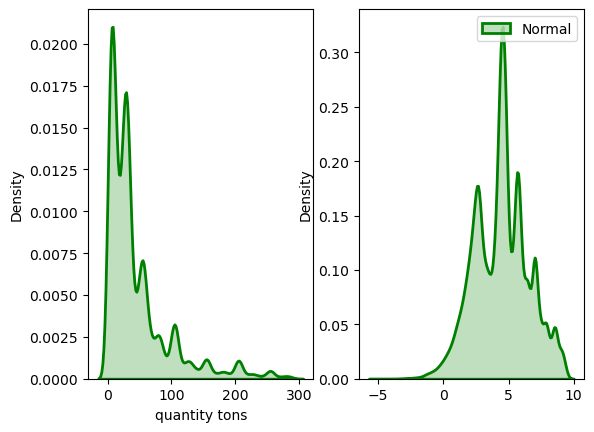

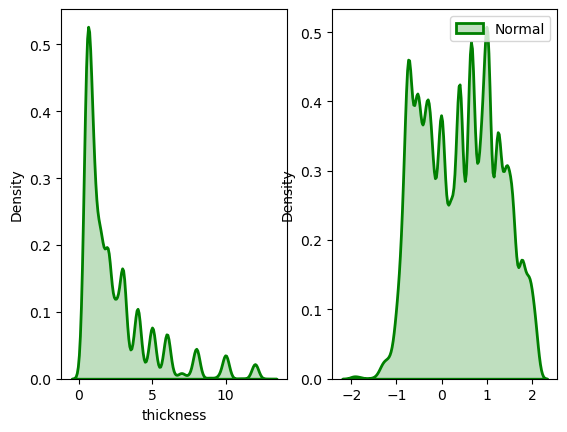

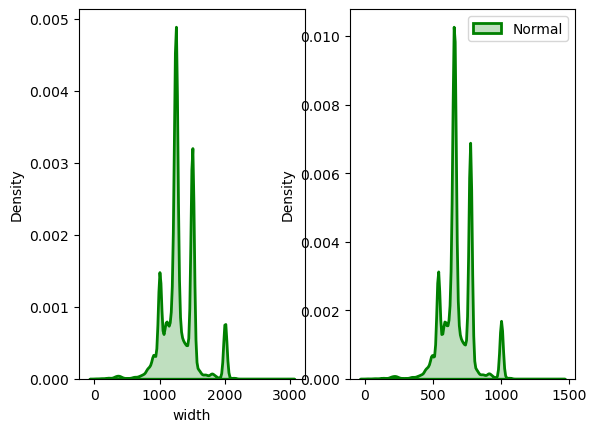

In [289]:
# Data transformation
features=['quantity tons', 'thickness', 'width']
for data in features:
    original_data = final_data[data]
    # transform training data & save lambda value
    fitted_data, fitted_lambda = boxcox(original_data)

    # creating axes to draw plots
    fig, ax = plt.subplots(1, 2)

    # plotting the original data(non-normal) and
    # fitted data (normal)
    sns.distplot(original_data, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2},
                label = "Non-Normal", color ="green", ax = ax[0])

    sns.distplot(fitted_data, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2},
                label = "Normal", color ="green", ax = ax[1])

    # adding legends to the subplots
    plt.legend(loc = "upper right")

    # # rescaling the subplots
    # fig.set_figheight(5)
    # fig.set_figwidth(10)

    print(f"Lambda value used for Transformation: {fitted_lambda}")
    final_data['quantity tons']=pd.DataFrame(fitted_data)


In [298]:
#handling missing values
final_data.isna().sum()

quantity tons       0
country             0
status              0
application         0
thickness           0
width               0
product_ref         0
selling_price       0
delivery_dats       0
item type_IPL       0
item type_Others    0
item type_PL        0
item type_S         0
item type_SLAWR     0
item type_W         0
item type_WI        0
dtype: int64

In [297]:
mead=final_data['quantity tons'].median()
final_data['quantity tons']=final_data['quantity tons'].fillna(mead)
mod=final_data['delivery_dats'].mode()
final_data['delivery_dats']=final_data['delivery_dats'].fillna(1)

**Applying a log transformation can help normalize the target variable's distribution, reduce the impact of extreme values,
and make the relationship with predictors more linear.**

In [292]:
Y = np.log(final_data['selling_price'])

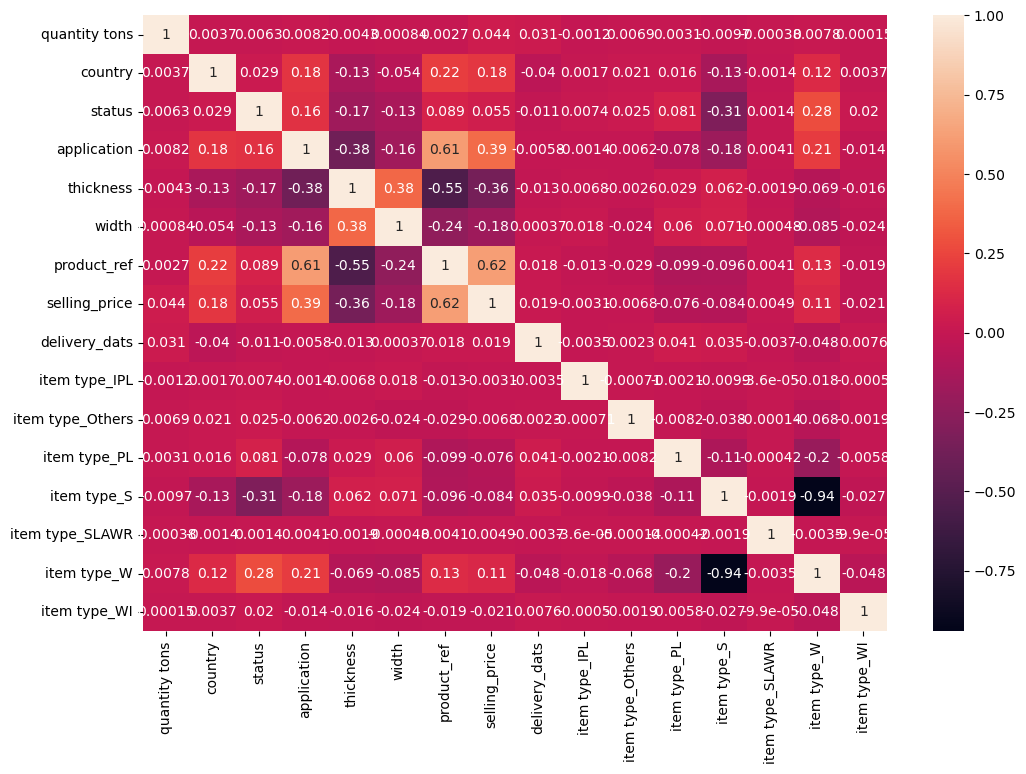

In [257]:
plt.figure(figsize=(12,8))
sns.heatmap(final_data.corr(), annot=True)
plt.show()

From above plot we can see that there no bmuch linear relationship between dependent and independent variables

# Model Building

In [299]:
#split the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score
import xgboost as xgb

In [305]:
final_data.columns

Index(['quantity tons', 'country', 'status', 'application', 'thickness',
       'width', 'product_ref', 'selling_price', 'delivery_dats',
       'item type_IPL', 'item type_Others', 'item type_PL', 'item type_S',
       'item type_SLAWR', 'item type_W', 'item type_WI'],
      dtype='object')

# Split the data

In [306]:
X=final_data.drop(columns=['selling_price','status','item type_IPL', 'item type_Others', 'item type_PL', 'item type_S',
       'item type_SLAWR', 'item type_W', 'item type_WI'])
y=Y
print(X.shape, y.shape)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

(140209, 7) (140209,)


**Gradient boosting regressor**

In [302]:
gbr= GradientBoostingRegressor() 
gbr.fit(X_train,y_train)
y_pred_gbr=gbr.predict(X_test)
r2_score(y_test,y_pred_gbr)

0.5327540656658001

**Random forest regressor**

In [307]:
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, y_train)
y_pred_rf= regr.predict(X_test) 
r2_score(y_test,y_pred_rf)

0.745431287099624

**XGBoost**

In [310]:
xgb_regr = xgb.XGBRegressor(objective ='reg:squarederror', random_state=0)
xgb_regr.fit(X_train, y_train)
y_pred_xgb = xgb_regr.predict(X_test)
r2_score(y_test, y_pred_xgb)

R^2 score for XGBoost Regressor: 0.6646857954492491


**Storing our best model into pickle file**

In [ ]:
import pickle

# Assuming you have trained your model and stored it in a variable called 'classifier'

# Save the model to a pickle file
with open('regressor_model_1.pkl', 'wb') as file:
    pickle.dump(gbr, file)

In [ ]:
pickle_file_path = r'C:\Users\Barry\Desktop\projects\indus_copper\regressor_model_1.pkl'
# Load the model from the pickle file
with open(pickle_file_path, 'rb') as file:
    model = pickle.load(file)

In [ ]:
# model predicting log values as we trained on log values of selling data
model.predict(X_test[2:3])

In [ ]:
# getting original predictive value taking antilog
np.exp(6.65)

In [ ]:
X.columns

## CLassification model building

In [ ]:
final_data.info()

In [ ]:
final_data['quantity tons']=final_data['quantity tons'].astype('int64')
final_data['application']=final_data['application'].astype('int64')
final_data['selling_price']=final_data['selling_price'].astype('int64')
final_data['thickness']=final_data['thickness'].astype('int64')
final_data['width']=final_data['width'].astype('int64')

In [ ]:
X1=final_data.drop(columns=['status'])
y1=final_data['status']
X1.shape, y1.shape
X1_train,X1_test,y1_train,y1_test=train_test_split(X1,y1,test_size=0.2,random_state=0)

In [ ]:
X1_test.head()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.ensemble import ExtraTreesClassifier

**Gradient boosting classifier**

In [ ]:
GB=GradientBoostingClassifier()
GB.fit(X1_train,y1_train)
GB_score=GB.score(X1_test,y1_test)
print("Accuracy:",GB_score, "   ","f1_score:",f1_score(y1_test,GB.predict(X1_test),average='macro'))

**DecisionTreeClassifier**

In [ ]:
DT=DecisionTreeClassifier()
DT.fit(X1_train,y1_train)
DT_score=DT.score(X1_test,y1_test)
print("Accuracy:",DT_score, "   ","f1_score:",f1_score(y1_test,DT.predict(X1_test),average='macro'))

**XGBClassifier**

In [ ]:
xgb_clf = xg.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_clf.fit(X1_train, y1_train)
y_pred = xgb_clf.predict(X1_test)
score = xgb_clf.score(X1_test, y1_test)

print("Accuracy:", score," ","f1 score",f1_score(y1_test,xgb_clf.predict(X1_test),average='macro'))

**Extra Tree Classifier**

In [ ]:
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)
etc.fit(X1_train, y1_train)
y_pred = etc.predict(X1_test)
score = etc.score(X1_test, y1_test)
print("Accuracy:", score," ","f1 score",f1_score(y1_test,etc.predict(X1_test),average='macro'))

In [ ]:
y_pred=etc.predict(X1_test)
from sklearn.metrics import roc_auc_score

# y_true: true binary labels (0 or 1)
# y_score: predicted probability scores (range between 0 and 1) or binary labels (0 or 1)
auroc_score = roc_auc_score(y1_test,y_pred)

print("AUROC Score: {:.4f}".format(auroc_score))

**Hyper parameter tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split

# Define the grid of hyperparameters to search
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(etc, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X1_train, y1_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the performance of the model on the testing data using the best hyperparameters
score = f1_score(y1_test,grid_search.predict(X1_test))
print("Score on testing data:", score)

In [ ]:
# Extra tree regressor with hyper parameter tuning
etc_tune = ExtraTreesClassifier(n_estimators=100, random_state=42,max_depth= None,max_features='auto',min_samples_leaf= 2, min_samples_split= 10)
etc_tune.fit(X1_train, y1_train)
y_pred = etc_tune.predict(X1_test)
score = etc_tune.score(X1_test, y1_test)
print("Accuracy:", score," ","f1 score",f1_score(y1_test,etc_tune.predict(X1_test),average='macro'))

In [ ]:
y_pred=etc_tune.predict(X1_test)
from sklearn.metrics import roc_auc_score

# y_true: true binary labels (0 or 1)
# y_score: predicted probability scores (range between 0 and 1) or binary labels (0 or 1)
auroc_score = roc_auc_score(y1_test,y_pred)

print("AUROC Score: {:.4f}".format(auroc_score))

**Comaprision between deafult and tuned model of extra tree regressor**

In [ ]:
pd.DataFrame({'f1_score':[0.68,0.67],'AUROC score':[0.651,0.651]},index=['Default ETC','Tuned ETC'])

In [ ]:
print(classification_report(y1_test, etc.predict(X1_test)))

In [ ]:
import pickle

# Assuming you have trained your model and stored it in a variable called 'classifier_model_1'

# Save the model to a pickle file
with open('classifier_model_1.pkl', 'wb') as file:
    pickle.dump(etc, file)